In [77]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)
print(tf.__version__)

path = 'C:\\Users\\WCW20000306\\Desktop\\data project\\Chest_Xray-Pneumonia_CNN_Classification'
os.chdir(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.9.1


## As the huge amount of dataset, please download it from Kaggle.
## Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## Image preprocessing

In [78]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height, width = 64, 64

def generate_data(DIR, batch_size=16):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=False,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'NORMAL': 0, 'PNEUMONIA': 1}
    )
    return generator

def generate_data_augmented(DIR):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=0.1,
        rotation_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1
    )
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=16,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'NORMAL': 0., 'PNEUMONIA': 1.}
    )
    return generator

TRAINING_DIR = 'chest_xray/train/'
VALIDATION_DIR = 'chest_xray/val/'
TESTING_DIR = 'chest_xray/test/'

train_generator = generate_data_augmented(TRAINING_DIR)
validation_generator = generate_data(VALIDATION_DIR)
test_generator = generate_data(TESTING_DIR)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Image demonstration

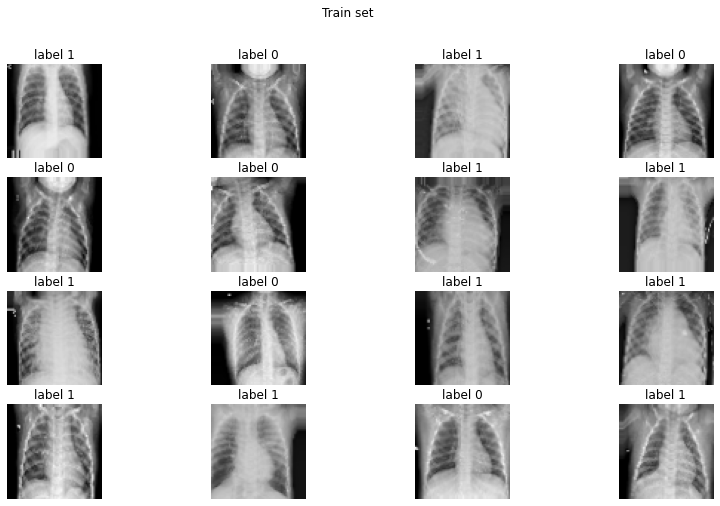

In [79]:
# view first image of each batch
# train
batch_num = math.ceil(2000/128)
col_num = 4
fig, ax = plt.subplots(int(batch_num/col_num), col_num, figsize=(14, 8))
fig.suptitle("Train set")
for k in range(batch_num):
    images, labels = train_generator.next()
    i, j = k//col_num, k%col_num
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')

## Building up the CNN model

In [80]:
# construct CNN model
tf.keras.backend.clear_session()
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(height,width,3)),
        tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#         tf.keras.layers.MaxPooling2D(2,2),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
#        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
#    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
    model.compile(optimizer = tf.optimizers.Adam(), loss = 'binary_crossentropy', metrics=['acc'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

## Training the CNN model

In [81]:
%%time
# train model
save_path = 'model/ts_clf_best.h5'

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=1, min_lr=0.000001)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_loss', verbose=1, save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=6)
cb_list = [checkpoint,early]

history = model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=validation_generator,
    callbacks=cb_list
)

Epoch 1/10
326/326 [==============================] - ETA: 0s - loss: 0.3775 - acc: 0.8386
Epoch 1: val_loss improved from inf to 0.84242, saving model to model\ts_clf_best.h5
326/326 [==============================] - 63s 191ms/step - loss: 0.3775 - acc: 0.8386 - val_loss: 0.8424 - val_acc: 0.6250
Epoch 2/10
326/326 [==============================] - ETA: 0s - loss: 0.1988 - acc: 0.9191
Epoch 2: val_loss improved from 0.84242 to 0.37647, saving model to model\ts_clf_best.h5
326/326 [==============================] - 62s 191ms/step - loss: 0.1988 - acc: 0.9191 - val_loss: 0.3765 - val_acc: 0.8125
Epoch 3/10
326/326 [==============================] - ETA: 0s - loss: 0.1788 - acc: 0.9281
Epoch 3: val_loss did not improve from 0.37647
326/326 [==============================] - 62s 192ms/step - loss: 0.1788 - acc: 0.9281 - val_loss: 0.4247 - val_acc: 0.6875
Epoch 4/10
326/326 [==============================] - ETA: 0s - loss: 0.1667 - acc: 0.9335
Epoch 4: val_loss did not improve from 0.37

## Model evaluation

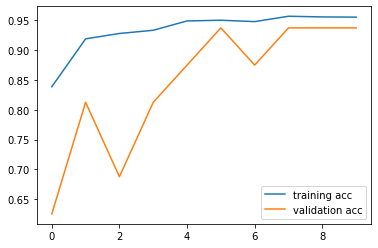

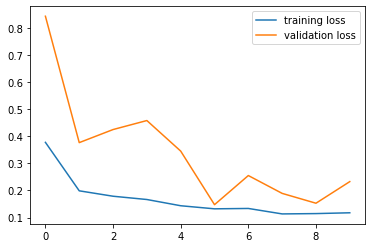

In [82]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [83]:
model.evaluate(test_generator)

39/39 [==============================] - 6s 147ms/step - loss: 0.5754 - acc: 0.8205


[0.5753855109214783, 0.8205128312110901]

39/39 [==============================] - 6s 146ms/step


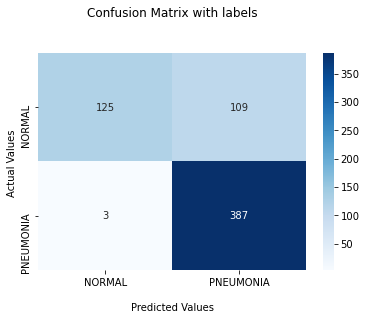

In [85]:
import seaborn as sns

ytest = test_generator.classes

ypred = model.predict(test_generator)
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])

cf = confusion_matrix(ytest, ypred)

ax = sns.heatmap(cf, annot=True, cmap='Blues',fmt='g')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['NORMAL','PNEUMONIA'])
ax.yaxis.set_ticklabels(['NORMAL','PNEUMONIA'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [86]:
print(classification_report(ytest, ypred))


              precision    recall  f1-score   support

           0       0.98      0.53      0.69       234
           1       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624

